In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols #more advanced than scikit-learn
from statsmodels.formula.api import ols as sm_ols

from statsmodels.tsa.stattools import adfuller #?
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score #haven't implemented the r2_score yet
from sklearn.linear_model import LinearRegression #haven't implemented yet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split #haven't implemented yet
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from math import sqrt
import seaborn as sns
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

import pandas_datareader as pdr 

In [2]:
end = dt.date(2020,10,1)
start = dt.date(2020,1,1)
#portfolio = 'SIZE' #SMART BETA FUND, Globalex ETF FACTOR FUND (MIN_VOLITILITY,MOM,VALUE)

fund = 'VIVAX' #Vanguard Value index 
fund_returns = pdr.get_data_yahoo(fund,start,end)      #['Adj Close'].pct_change()

fund_returns = fund_returns.filter(like='Adj Close')
#stock_prices.columns = stock # put their tickers as column name
fund_returns.reset_index() # print
fund_returns.columns = ['Adj Close']
fund_returns.reset_index()

fund_returns[fund + ' ret_daily'] = fund_returns['Adj Close'].pct_change() #currently in decimal format
fund_returns[fund + ' log_ret_daily'] = np.log(1 + fund_returns[fund + ' ret_daily']) #daily log returns 

fund_returns = fund_returns[1:] #don't include first day so we have all return values 
fund_returns.reset_index()
fund_returns

#fund_returns = fund_returns.resample('M').agg(lambda x:(x+1).prod()-1) #monthly returns axis by month 
#fund_returns_mt = fund_returns_mt[:-1] #have an error message in next chunk when this is not commented out 
#fund_returns_mt.plot()

#fund_returns.plot()
fund_returns


,Adj Close,VIVAX ret_daily,VIVAX log_ret_daily
Date,,,
2020-01-03,45.058971,-0.007450,-0.007478
2020-01-06,45.107285,0.001072,0.001072
2020-01-07,44.923683,-0.004070,-0.004079
2020-01-08,45.039642,0.002581,0.002578
2020-01-09,45.242569,0.004506,0.004495
...,...,...,...
2020-09-25,39.675629,0.010829,0.010770
2020-09-28,40.268692,0.014948,0.014837
2020-09-29,39.962276,-0.007609,-0.007638


In [3]:
# factors = reader.DataReader('F-F_Research_Data_Factors','famafrench',start,end)
# factors = factors[0]
# factors

ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2019,end=2021)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"}) 
ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] / 100 #convert to decimal format 
ff

,Date,mkt_excess,SMB,HML,RMW,CMA,RF
0,2019-01-02,0.0023,0.0072,0.0110,-0.0012,0.0026,0.0001
1,2019-01-03,-0.0245,0.0052,0.0121,-0.0025,0.0091,0.0001
2,2019-01-04,0.0355,0.0037,-0.0070,-0.0008,-0.0058,0.0001
3,2019-01-07,0.0094,0.0084,-0.0077,-0.0069,-0.0041,0.0001
4,2019-01-08,0.0101,0.0045,-0.0064,0.0036,-0.0009,0.0001
...,...,...,...,...,...,...,...
500,2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.0000
501,2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.0000
502,2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.0000
503,2020-12-30,0.0027,0.0103,0.0004,-0.0067,-0.0006,0.0000


In [4]:
#fund_returns.index = factors.index


full_dataset = pd.merge(fund_returns,ff,on='Date',how='inner')
full_dataset
full_dataset[fund + '_excess']= full_dataset[fund + ' ret_daily'] - full_dataset['RF'] #Excess Return = daily ret of fund - RF
full_dataset
train = (len(full_dataset)*.8)
train = math.floor(train)
train_data = full_dataset.iloc[0:train, :]
test_data = full_dataset.iloc[train:, :]
train_data.head()

,Date,Adj Close,VIVAX ret_daily,VIVAX log_ret_daily,mkt_excess,SMB,HML,RMW,CMA,RF,VIVAX_excess
0,2020-01-03,45.058971,-0.007450,-0.007478,-0.0067,0.0028,0.0002,-0.0018,-0.0015,0.00006,-0.007510
1,2020-01-06,45.107285,0.001072,0.001072,0.0036,-0.0022,-0.0056,-0.0019,-0.0032,0.00006,0.001012
2,2020-01-07,44.923683,-0.004070,-0.004079,-0.0019,-0.0004,-0.0021,-0.0011,-0.0031,0.00006,-0.004130
3,2020-01-08,45.039642,0.002581,0.002578,0.0047,-0.0017,-0.0063,-0.0017,-0.0012,0.00006,0.002521
4,2020-01-09,45.242569,0.004506,0.004495,0.0065,-0.0071,-0.0048,-0.0014,0.0006,0.00006,0.004446


In [5]:
full_dataset[[fund + '_excess','mkt_excess']].describe()
#full_dataset[fund + '_excess'].hist()

#KS_Test = sm.stats.diagnostic.kstest_normal(full_dataset[fund + '_excess'],dist= 'norm')

,VIVAX_excess,mkt_excess
count,189.000000,189.000000
mean,-0.000333,0.000668
std,0.024953,0.024430
min,-0.112846,-0.120000
25%,-0.008152,-0.007800
50%,0.000495,0.002700
75%,0.010248,0.010900
max,0.096800,0.093400


In [6]:
sm_ols('VIVAX_excess ~ mkt_excess + SMB + HML + RMW + CMA', data=full_dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VIVAX_excess   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2088.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):          2.71e-159
Time:                        23:06:06   Log-Likelihood:                 813.66
No. Observations:                 189   AIC:                            -1615.
Df Residuals:                     183   BIC:                            -1596.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001      0.000     -0.550      0.583      -0.001       0.000
mkt_excess     0.9455      0.011     86.632      0.000       0.924       0.967
SMB           -0.0729      0.029     -2.474      0.014      -0.131      -0.015
HML            0.2811      0.024     11.590      0.000       0.233       0.329
RMW           -0.1551      0.050     -3.120      0.002      -0.253      -0.057
CMA            0.5092      0.067      7.647      0.000       0.378       0.641
==============================================================================
Omnibus:                       16.389   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.326
Skew:                           0.340   Prob(JB):                     7.85e-09
Kurtosis:                       5.068   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
x_train = train_data[['mkt_excess','SMB','HML']]
y_train = train_data['VIVAX_excess']
x_test = test_data[['mkt_excess','SMB','HML']]
y_test = test_data['VIVAX_excess']
x = sm.add_constant(x_train) #add's a non-zero alpha into regression
x_t = sm.add_constant(x_test) #add's a non-zero alpha into regression

                            OLS Regression Results                            
Dep. Variable:           VIVAX_excess   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2767.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):          4.67e-129
Time:                        23:06:06   Log-Likelihood:                 634.75
No. Observations:                 151   AIC:                            -1261.
Df Residuals:                     147   BIC:                            -1249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -1.347      0.1

/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


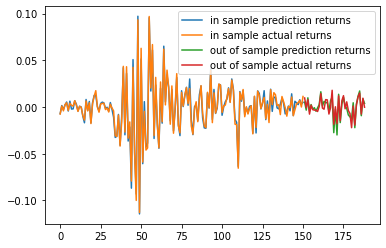

In [8]:
#Modeling & Plotting Results
model = sm.OLS(y_train,x)
results = model.fit()
print(results.summary())
results.params 
results.rsquared
y_hat_train = results.predict(x) #in sample prediction
y_hat_test = results.predict(x_t) #out of sample prediction
y_hat_train.plot(label = 'in sample prediction returns') #green, in-sample prediction 
y_train.plot(label = 'in sample actual returns ') #yellow, in-sample actual excess
y_hat_test.plot(label = 'out of sample prediction returns') #blue, out of sample prediciton
y_test.plot(label = 'out of sample actual returns') # red, out of sample actual excess
ax = plt.subplot()
#ax.plot(y_hat_train, label = "In-Sample Prediction")
#ax.plot(y_hat_test, label = "Out-of-Sample Prediction")
#ax.plot(y_train, label = 'In-Sample Actual')
#ax.plot(y_test, label = 'Out-of-Sample Actual')
ax.legend()

In [9]:
#table = sm.stats.anova_lm(results, typ = 2)

The in-sample MSE is 1.0727462151620613e-36


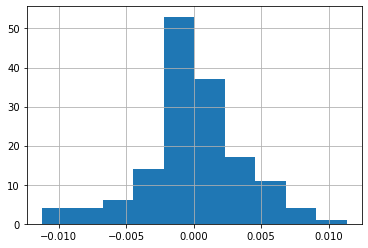

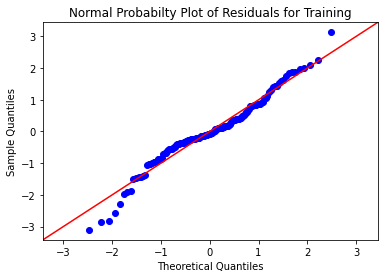

0.0036153016411640056
0.004518217284215781


In [10]:
# Residuals/Epsilon Analysis
train_residuals = y_train - y_hat_train #residual in sample
test_residuals =  y_test - y_hat_test #residuals out of sample  
train_MSE = ((train_residuals.mean())**2)**1/2
print("The in-sample MSE is " +str(train_MSE))
train_residuals.hist() #in-sample residual/noise aka unpredicted deviation (histogram)
pplot = sm.ProbPlot(train_residuals,fit = True) #normal prob plot in-sample
fig = pplot.qqplot(line = '45')
plt.title("Normal Probabilty Plot of Residuals for Training")
plt.show()

rmse_train = sqrt(mean_squared_error(y_train, y_hat_train))
rmse_test = sqrt(mean_squared_error(y_test, y_hat_test))

print(rmse_train) #~0.0054
print(rmse_test) #~0.0121



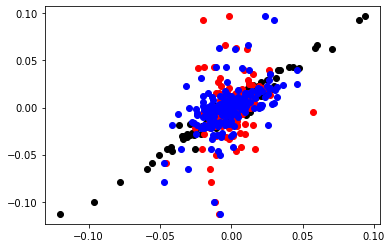

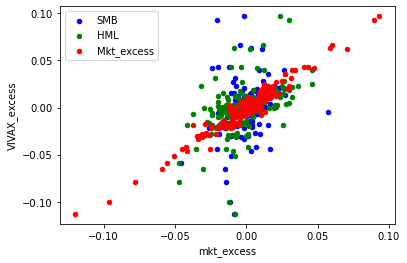

In [11]:
#sns.regplot(full_dataset['SIZE - RF'],
           # full_dataset['HML'],full_dataset['SMB'],)

#plt.scatter,full_dataset['HML'])


x_HML = full_dataset['HML']
x_SMB = full_dataset['SMB']
x_mkt_excess = full_dataset['mkt_excess']
y_port = full_dataset['VIVAX_excess']
x1=np.array(x_mkt_excess)
x2=np.array(x_SMB)
x3=np.array(x_HML)
Y=y_port
X = np.array([x1,x2,x3])

#establising y intercept
#m1, b1 = np.polyfit(x1, Y, 1)
#m2, b2 = np.polyfit(x2, Y, 1)
#m3, b3 = np.polyfit(x3, Y, 1)
#print(b1,m1)
#print(b2,m2)
#print(b3,m3)

'''''
regression_line_x1 = []
for x in x1:
    regression_line_x1.append((m1*x1)+b1)

regression_line_x2 = []
for x in x2:
    regression_line_x2.append((m1*x2)+b2)

regression_line_x3 = []
for x in x3:
    regression_line_x3.append((m1*x3)+b3)
    
'''''

fig =plt.figure()
ax =plt.axes()
plt.scatter(x1,Y,color=['black'], label = 'mkt_excess',) #Mkt-RF
plt.scatter(x2,Y,color=['red'], label = 'SMB') #SMB
plt.scatter(x3,Y,color=['blue'], label = 'HML') #HML

#respective trend lines
#plt.plot(x1, m1*x1 + b1, color = 'Blue') 
#plt.plot(x2, m2*x2 + b2, color = 'Green')
#plt.plot(x3, m3*x3 + b3, color = 'Red')

#don't know what this means but regression line is all over the place 
#plt.plot(x1,x2,x3, (m1*x1 + b1) + (m2*x2 + b2) + (m3*x3 + b3), color = 'Yellow')  #doesn't accoun for covariance


plt.show()


'''''
for some reason its plotting numerous horizontal lines...
#plt.plot(x1,regression_line_x1)
#plt.plot(x2,regression_line_x2)
#plt.plot(x3,regression_line_x3)
'''''


#scatterplot for SMB and SIZE 
ax1=full_dataset.plot(kind='scatter',x='SMB',y='VIVAX_excess',
                  color='Blue', label = 'SMB')

#scatterplot adding HML
ax1= full_dataset.plot(kind='scatter',x='HML',y='VIVAX_excess',
                  color='Green', label = 'HML', ax = ax1)

#scatterplot for SMB and SIZE 


ax2= full_dataset.plot(kind='scatter',x='mkt_excess',y='VIVAX_excess',
                  color='Red', label = 'Mkt_excess', ax = ax1)


#want to grup by clusters by decade 


In [12]:
'''''
#fitting curve
def func(x, a, b): #a and b are parameters found using optimizer
    return a*np.exp(b*x)
    #return  a*x+b

plt.plot(x1, y, 'bo', label = "linear")

popt, pcov = curve_fit(func, x1, y) #function fitting data 
print(popt)

plt.plot(x1, func(x1, *popt), 'r', label = 'fit')
'''''


'\'\'\n#fitting curve\ndef func(x, a, b): #a and b are parameters found using optimizer\n    return a*np.exp(b*x)\n    #return  a*x+b\n\nplt.plot(x1, y, \'bo\', label = "linear")\n\npopt, pcov = curve_fit(func, x1, y) #function fitting data \nprint(popt)\n\nplt.plot(x1, func(x1, *popt), \'r\', label = \'fit\')\n'

In [13]:
full_dataset.columns

Index(['Date', 'Adj Close', 'VIVAX ret_daily', 'VIVAX log_ret_daily',
       'mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'VIVAX_excess'],
      dtype='object')

In [14]:
#autocorrelation
sm.graphics.tsa.plot_acf(full_dataset['VIVAX - RF'],alpha = .01, title = 'Excess Returns ACF')
sm.graphics.tsa.plot_pacf(full_dataset['VIVAX - RF'],alpha = .01, title = 'Excess Returns PACF')
result_ADF = adfuller((full_dataset['VIVAX - RF']))
print('ADF Statistic: %f' % result_ADF[0])
print('P Value: %f' % result_ADF[1])
print('Critical Values:')
for key, value in result_ADF[4].items():
    print('\t%s: %.3f' % (key,value))

KeyError: 'VIVAX - RF'

In [ ]:
#10x10 correlation matrix 

#rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(6,6))
corr = full_dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
#covariance matrix (transposed where each columns is a variable and each row are observations)

#bias=true allows you to calculate population covariance (not normalized)

#creating covariance as a defined variable 
cov_matrix = np.cov(X, Y, bias=True)
print(cov_matrix)

#covariance heatmap
labels = ['Portfolio', 'Mkt - RF', 'SMB', 'HML']
sns.heatmap(cov_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)



In [ ]:
#quicker way to run regression but need to reshape arrays into 2 dimentional to make it work

regress = linear_model.LinearRegression()
regress_x1 = regress.fit(x1.reshape(-1,1),Y)
regress_x2 = regress.fit(x2.reshape(-1,1),Y)
regress_x3 = regress.fit(x3.reshape(-1,1),Y) #outputs a 80% r correlation 

regress.coef_



In [35]:
dataset_daily = full_dataset
dataset_daily['vivax_ret_t_minus_one'] = dataset_daily['VIVAX_excess'].shift(1)
dataset_daily['vivax_ret_t_minus_two'] = dataset_daily['VIVAX_excess'].shift(2)

dataset_daily

,Adj Close,VIVAX ret_daily,VIVAX log_ret_daily,mkt_excess,SMB,HML,RMW,CMA,RF,VIVAX_excess,vivax_ret_t_minus_one,vivax_ret_t_minus_two
Date,,,,,,,,,,,,
2020-01-03,45.058971,-0.007450,-0.007478,-0.0067,0.0028,0.0002,-0.0018,-0.0015,0.00006,-0.007510,NaN,NaN
2020-01-06,45.107285,0.001072,0.001072,0.0036,-0.0022,-0.0056,-0.0019,-0.0032,0.00006,0.001012,-0.007510,NaN
2020-01-07,44.923683,-0.004070,-0.004079,-0.0019,-0.0004,-0.0021,-0.0011,-0.0031,0.00006,-0.004130,0.001012,-0.007510
2020-01-08,45.039642,0.002581,0.002578,0.0047,-0.0017,-0.0063,-0.0017,-0.0012,0.00006,0.002521,-0.004130,0.001012
2020-01-09,45.242569,0.004506,0.004495,0.0065,-0.0071,-0.0048,-0.0014,0.0006,0.00006,0.004446,0.002521,-0.004130
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-25,39.675629,0.010829,0.010770,0.0172,-0.0016,-0.0135,-0.0050,-0.0070,0.00000,0.010829,0.002170,-0.019420
2020-09-28,40.268692,0.014948,0.014837,0.0166,0.0086,0.0102,0.0036,0.0019,0.00000,0.014948,0.010829,0.002170
2020-09-29,39.962276,-0.007609,-0.007638,-0.0042,0.0042,-0.0130,-0.0078,-0.0059,0.00000,-0.007609,0.014948,0.010829


In [16]:
sm_ols('vivax_ret_t_minus_one ~ mkt_excess + SMB + HML + RMW + CMA', data=dataset_daily).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     vivax_ret_t_minus_one   R-squared:                       0.153
Model:                               OLS   Adj. R-squared:                  0.129
Method:                    Least Squares   F-statistic:                     6.557
Date:                   Sun, 11 Apr 2021   Prob (F-statistic):           1.24e-05
Time:                           23:07:43   Log-Likelihood:                 442.67
No. Observations:                    188   AIC:                            -873.3
Df Residuals:                        182   BIC:                            -853.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.002      0.342      0.733      -0.003       0.004
mkt_excess    -0.4165      0.077     -5.424      0.000      -0.568      -0.265
SMB           -0.0502      0.207     -0.242      0.809      -0.459       0.359
HML            0.2896      0.171      1.697      0.091      -0.047       0.626
RMW           -0.2043      0.350     -0.585      0.560      -0.894       0.485
CMA            0.0724      0.468      0.155      0.877      -0.852       0.996
==============================================================================
Omnibus:                       30.439   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.219
Skew:                          -0.552   Prob(JB):                     5.22e-24
Kurtosis:                       6.531   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# dataset_daily.Date = pd.to_datetime(dataset_daily.Date)
# dataset_daily.set_index('Date', inplace=True)

dataset_monthly = dataset_daily.resample('MS').sum()
dataset_monthly['vivax_ret_t_minus_one'] = dataset_monthly['VIVAX_excess'].shift(1)
dataset_monthly['vivax_ret_t_minus_two'] = dataset_monthly['VIVAX_excess'].shift(2)

dataset_monthly



,Adj Close,VIVAX ret_daily,VIVAX log_ret_daily,mkt_excess,SMB,HML,RMW,CMA,RF,VIVAX_excess,vivax_ret_t_minus_one,vivax_ret_t_minus_two
Date,,,,,,,,,,,,
2020-01-01,902.822113,-0.029374,-0.029814,-0.0090,-0.0356,-0.0608,-0.0159,-0.0208,0.00120,-0.030574,NaN,NaN
2020-02-01,843.278206,-0.101322,-0.103656,-0.0823,0.0001,-0.0428,-0.0163,-0.0273,0.00114,-0.102462,-0.030574,NaN
2020-03-01,774.168474,-0.119887,-0.158297,-0.1068,-0.0941,-0.1544,-0.0248,0.0130,0.00132,-0.121207,-0.102462,-0.030574
2020-04-01,756.759678,0.108733,0.101588,0.1344,0.0305,-0.0051,0.0242,-0.0110,0.00000,0.108733,-0.121207,-0.102462
2020-05-01,737.675468,0.030737,0.027659,0.0567,0.0220,-0.0396,0.0091,-0.0300,0.00000,0.030737,0.108733,-0.121207
2020-06-01,858.039047,-0.005233,-0.010004,0.0285,0.0223,-0.0151,0.0024,0.0033,0.00000,-0.005233,0.030737,0.108733
2020-07-01,862.153751,0.036282,0.035348,0.0569,-0.0276,-0.0116,0.0062,0.0101,0.00000,0.036282,-0.005233,0.030737
2020-08-01,856.468895,0.041978,0.041546,0.0741,-0.0079,-0.0265,0.0404,-0.0133,0.00000,0.041978,0.036282,-0.005233
2020-09-01,851.633240,-0.021028,-0.022528,-0.0342,0.0016,-0.0275,-0.0119,-0.0186,0.00000,-0.021028,0.041978,0.036282


In [45]:
sm_ols('VIVAX_excess ~ vivax_ret_t_minus_one + vivax_ret_t_minus_two', data=dataset_monthly).fit().summary()
#sm_ols('vivax_ret_t_minus_one ~ mkt_excess + SMB + HML + RMW + CMA', data=dataset_monthly).fit().summary()

/Users/Jordan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VIVAX_excess   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                 -0.235
Method:                 Least Squares   F-statistic:                    0.3334
Date:                Sun, 11 Apr 2021   Prob (F-statistic):              0.731
Time:                        23:36:41   Log-Likelihood:                 11.441
No. Observations:                   8   AIC:                            -16.88
Df Residuals:                       5   BIC:                            -16.64
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0077      0.026      0.298      0.778      -0.059       0.075
vivax_ret_t_minus_one     0.1166      0.364      0.321      0.761      -0.818       1.051
vivax_ret_t_minus_two    -0.2854      0.362     -0.789      0.466      -1.216       0.645
==============================================================================
Omnibus:                        4.049   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                0.993
Skew:                          -0.837   Prob(JB):                        0.609
Kurtosis:                       3.422   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm_ols('vivax_ret_t_minus_one ~ ', data=dataset_monthly).fit().summary()

In [33]:
dataset_monthly_adj = dataset_daily.reset_index()
dataset_monthly_adj['one_r'] = dataset_monthly_adj['VIVAX_excess']+1
dataset_monthly_adj['Month'] = dataset_monthly_adj['Date'].dt.month
dataset_monthly_adj.groupby('Month')['one_r'].prod()-1
#notice how they slightly differ from whats above 

Month
1    -0.030540
2    -0.099498
3    -0.147540
4     0.106927
5     0.028045
6    -0.009954
7     0.035980
8     0.042421
9    -0.022276
10   -0.000245
Name: one_r, dtype: float64